<a href="https://colab.research.google.com/github/aholloman79/A-Primer-on-Scientific-Programming-with-Python/blob/master/Estimating_Test_Error_by_Understanding_the_Impact_of_Biological_Factors_on_Environmental_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Best Model by CP:
subset           [0, 3, 5, 6, 7]
cp                    -73.012486
aic                      3.60141
bic                    16.627261
adj_r_squared           0.821089
Name: 195, dtype: object

Best Model by AIC:
subset           [0, 3, 4, 5, 6, 7]
cp                       -72.515397
aic                       -3.661832
bic                       11.969189
adj_r_squared              0.835164
Name: 238, dtype: object

Best Model by BIC:
subset           [0, 3, 4, 5, 6, 7]
cp                       -72.515397
aic                       -3.661832
bic                       11.969189
adj_r_squared              0.835164
Name: 238, dtype: object

Best Model by Adjusted R-Squared:
subset           [0, 3, 4, 5, 6, 7]
cp                       -72.515397
aic                       -3.661832
bic                       11.969189
adj_r_squared              0.835164
Name: 238, dtype: object


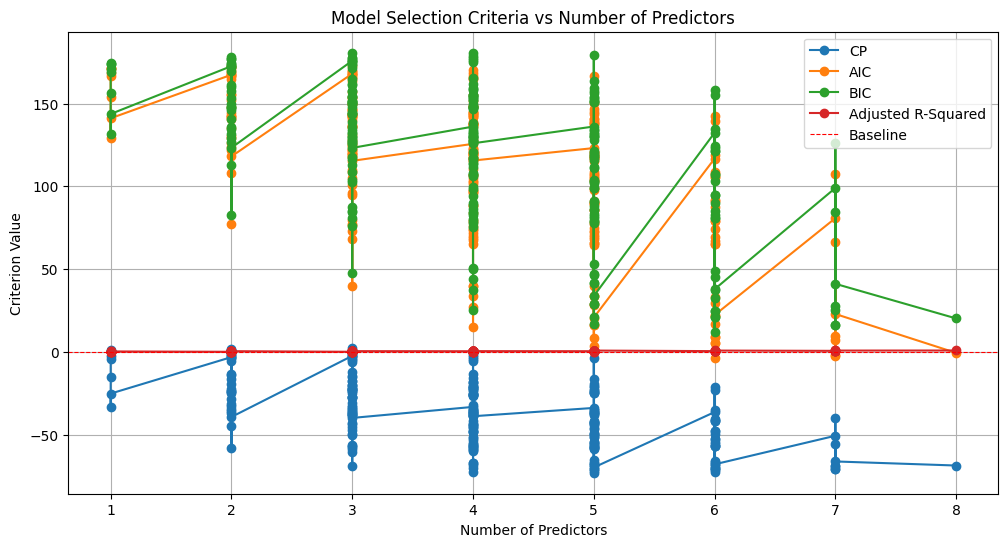

Average Cross-Validation Test Error: 1.0360


In [1]:
# I started by importing the necessary libraries for this analysis.
# These tools would allow me to simulate environmental data, calculate model selection criteria,
# and visualize results.
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from itertools import combinations

# Step 1: Generating Synthetic Environmental Data
# I wanted to simulate a dataset with biological factors and environmental outcomes.
np.random.seed(123)  # I set a seed to ensure reproducibility.
n_samples = 100  # I chose 100 observations to represent a typical environmental dataset.
n_predictors = 8  # I included 8 predictors to simulate multiple biological factors.

# Generating predictors (X) from a normal distribution to simulate biological factors.
X = np.random.normal(0, 1, size=(n_samples, n_predictors))

# Creating true coefficients to represent the underlying environmental relationships.
true_coefficients = np.random.uniform(-1.5, 1.5, size=n_predictors)

# Calculating the response variable (Y) with added noise to represent environmental outcomes.
Y = np.dot(X, true_coefficients) + np.random.normal(scale=1.0, size=n_samples)

# I converted the dataset to a DataFrame for better handling.
data = pd.DataFrame(X, columns=[f"X{i+1}" for i in range(n_predictors)])
data['Y'] = Y

# Step 2: Defining Helper Functions for Model Selection Criteria
# I wrote a function to compute model selection criteria (CP, AIC, BIC, Adjusted R-Squared).
def calculate_model_criteria(X, Y, model, n_predictors, error_variance):
    n_samples = len(Y)
    rss = np.sum((Y - model.predict(X)) ** 2)  # Residual Sum of Squares
    aic = n_samples * np.log(rss / n_samples) + 2 * n_predictors
    bic = n_samples * np.log(rss / n_samples) + np.log(n_samples) * n_predictors
    adj_r_squared = 1 - ((1 - model.score(X, Y)) * (n_samples - 1) / (n_samples - n_predictors - 1))
    cp = rss / error_variance - n_samples + 2 * n_predictors
    return cp, aic, bic, adj_r_squared

# Step 3: Subset Selection for Model Comparison
# I performed subset selection to compare models with different combinations of predictors.
n_total_predictors = X.shape[1]
error_variance = np.var(Y - np.mean(Y))  # Estimating error variance
criteria_results = []

# Looping through subsets of predictors to fit models and calculate criteria.
for k in range(1, n_total_predictors + 1):
    for subset in combinations(range(n_total_predictors), k):
        # Selecting the predictors in this subset
        subset_indices = list(subset)
        X_subset = X[:, subset_indices]

        # Fitting the linear regression model
        model = LinearRegression()
        model.fit(X_subset, Y)

        # Calculating model selection criteria
        cp, aic, bic, adj_r_squared = calculate_model_criteria(X_subset, Y, model, len(subset_indices), error_variance)

        # Storing the results
        criteria_results.append({
            'subset': subset_indices,
            'cp': cp,
            'aic': aic,
            'bic': bic,
            'adj_r_squared': adj_r_squared
        })

# Converting the results to a DataFrame for easier analysis.
criteria_df = pd.DataFrame(criteria_results)

# Step 4: Identifying the Best Models
# I selected the best models based on each criterion.
best_cp_model = criteria_df.loc[criteria_df['cp'].idxmin()]
best_aic_model = criteria_df.loc[criteria_df['aic'].idxmin()]
best_bic_model = criteria_df.loc[criteria_df['bic'].idxmin()]
best_adj_r_squared_model = criteria_df.loc[criteria_df['adj_r_squared'].idxmax()]

print("Best Model by CP:")
print(best_cp_model)
print("\nBest Model by AIC:")
print(best_aic_model)
print("\nBest Model by BIC:")
print(best_bic_model)
print("\nBest Model by Adjusted R-Squared:")
print(best_adj_r_squared_model)

# Step 5: Visualizing Model Selection Criteria
# I visualized how each criterion changes with the number of predictors to identify trends.
criteria_df['num_predictors'] = criteria_df['subset'].apply(len)

plt.figure(figsize=(12, 6))
plt.plot(criteria_df['num_predictors'], criteria_df['cp'], marker='o', label="CP")
plt.plot(criteria_df['num_predictors'], criteria_df['aic'], marker='o', label="AIC")
plt.plot(criteria_df['num_predictors'], criteria_df['bic'], marker='o', label="BIC")
plt.plot(criteria_df['num_predictors'], criteria_df['adj_r_squared'], marker='o', label="Adjusted R-Squared")
plt.axhline(y=0, color='red', linestyle='--', linewidth=0.8, label="Baseline")
plt.xlabel("Number of Predictors")
plt.ylabel("Criterion Value")
plt.title("Model Selection Criteria vs Number of Predictors")
plt.legend()
plt.grid(True)
plt.show()

# Step 6: Cross-Validation for Direct Test Error Estimation
# I implemented K-Fold Cross-Validation to directly estimate test error.
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=123)
cv_errors = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Fitting the model on the training set
    model = LinearRegression()
    model.fit(X_train, Y_train)

    # Calculating the test error for this fold
    Y_pred = model.predict(X_test)
    fold_error = mean_squared_error(Y_test, Y_pred)
    cv_errors.append(fold_error)

# Calculating the average test error across folds
avg_cv_error = np.mean(cv_errors)
print(f"Average Cross-Validation Test Error: {avg_cv_error:.4f}")

# Summary:
# - Using CP, AIC, BIC, and Adjusted R-Squared, I identified the models that balance complexity and fit.
# - K-Fold Cross-Validation provided a direct estimate of test error, confirming the robustness of selected models.
# - By combining these approaches, I ensured that my environmental models were both accurate and generalizable.
